In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import sepfir2d,convolve2d
from scipy.ndimage import convolve


#### cv.imread using BGR format but plt using RGB format

(770, 1401, 3)


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [115,  79,   3, ...,   0,   0,   0],
       ...,
       [114, 151, 234, ..., 112, 114, 115],
       [117, 154, 238, ..., 109, 111, 112],
       [120, 157, 242, ..., 107, 108, 110]], dtype=uint8)

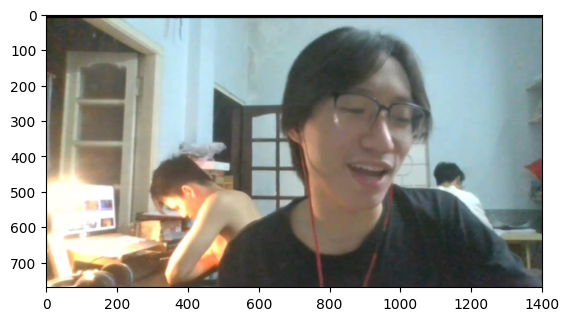

In [2]:
img = cv.imread('./img/bai1.png')
b,g,r=cv.split(img)
img=cv.merge((r,g,b))
plt.imshow(img)
print(img.shape)
b

# Negative Image

## Before

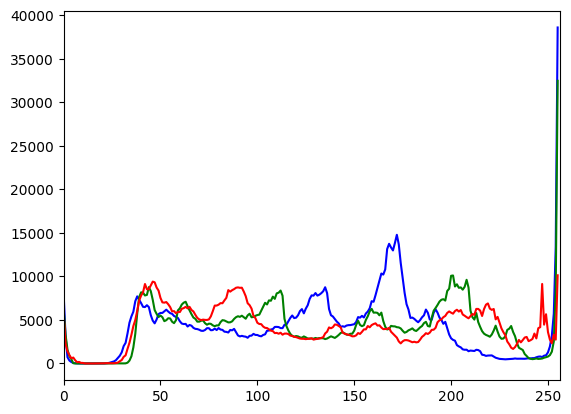

In [27]:
color = ('b', 'g', 'r') 
  
for i, col in enumerate(color): 
      
    histr = cv.calcHist([img],  
                         [i], None, 
                         [256],  
                         [0, 256]) 
      
    plt.plot(histr, color = col) 
      
    # Limit X - axis to 256 
    plt.xlim([0, 256]) 
      
plt.show() 

## After

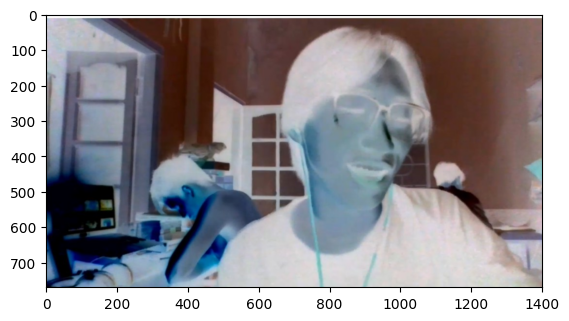

In [68]:
img1=img.copy()
# Slow
# height,width,_=img1.shape
# for i in range(0,height-1):
#     for j in range(0,width-1):
#         pixel=img1[i,j]
#         # red
#         pixel[0] = 255 - pixel[0]
#         # green
#         pixel[1] = 255 - pixel[1]
#         # blue
#         pixel[2] = 255 - pixel[2]
#         # Store new values in the pixel
#         img1[i, j] = pixel
#Vectorize
img1=255-img1
plt.imshow(img1)
plt.show()

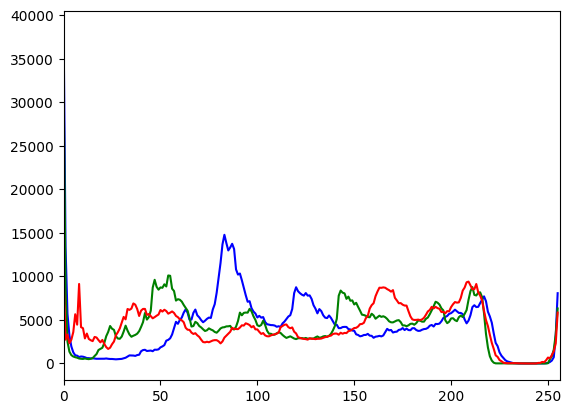

In [37]:
color = ('b', 'g', 'r') 
  
for i, col in enumerate(color): 
      
    histr = cv.calcHist([img1],  
                         [i], None, 
                         [256],  
                         [0, 256]) 
      
    plt.plot(histr, color = col) 
      
    # Limit X - axis to 256 
    plt.xlim([0, 256]) 
      
plt.show() 

# Gaussian filter

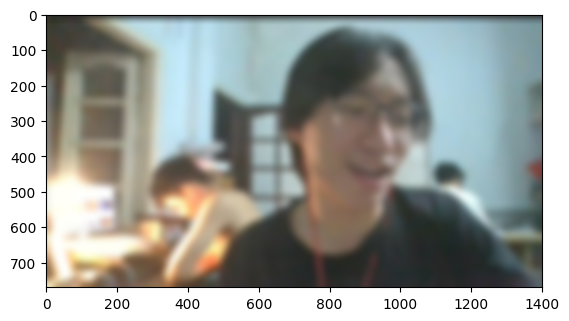

In [301]:
gauss_blurred = cv.GaussianBlur(img, (41, 41), sigmaX=10, sigmaY=10)#rule of thumb: k=2*pi*sigma
plt.imshow(gauss_blurred)

# Median filter

In [ ]:
# Áp dụng bộ lọc trung vị để lọc nhiể.u muô/i tiểu
noise_mask = np.random.randint(0, 21, size = (img.shape[0],
img.shape[1]), dtype=int)
zeros_pixel = np.where(noise_mask == 0)
one_pixel = np.where(noise_mask == 20)
pepper_salt_img = img.copy()
pepper_salt_img[zeros_pixel] = [0, 0, 0]
pepper_salt_img[one_pixel] = [255, 255, 255]
plt.imshow(pepper_salt_img)
plt.show()
median_blurred = cv.medianBlur(pepper_salt_img, 3)
plt.imshow(median_blurred)

# Sobel filter

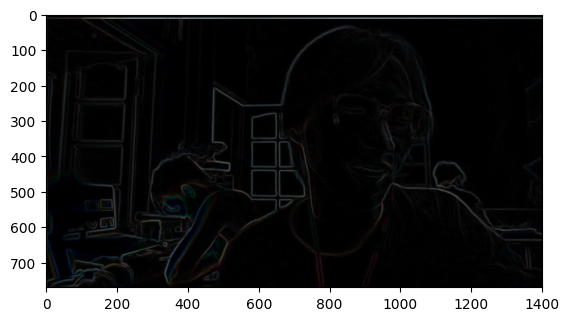

In [60]:
# Áp dụng bộ lọc Sobel 
img_gray = img.copy()
grad_x = cv.Sobel(src=img_gray, ddepth=cv.CV_64F, dx=1, dy=0,
ksize=5)
grad_y = cv.Sobel(src=img_gray, ddepth=cv.CV_64F, dx=0, dy=1,
ksize=5)
grad = np.sqrt(grad_x**2 + grad_y**2)
sobel = (grad * 255 / grad.max()).astype(np.uint8) # grảd normảlized
plt.imshow(sobel)

# Laplacian filter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


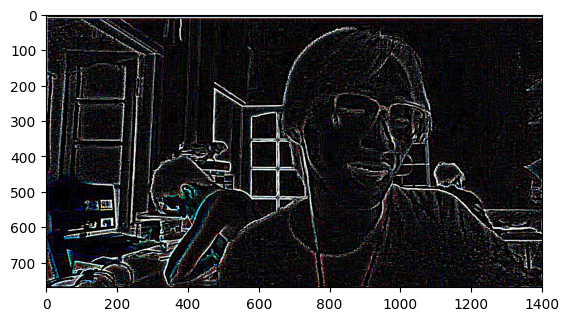

In [408]:
laplacian = cv.Laplacian(img, ddepth=cv.CV_64F, ksize=5)
plt.imshow(laplacian.astype(int))

# Gaussian Pyramid
## Using blur+downsample for each level to get down to new image with lower size

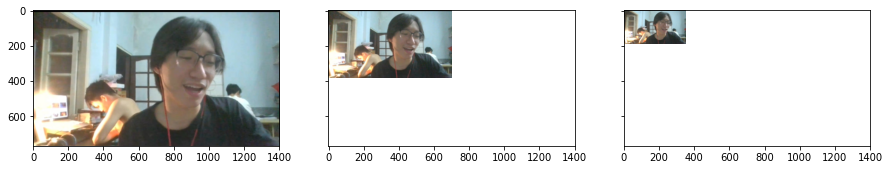

In [421]:
im_pyramid = img.copy()
N=3 # number of pyramid levels
P=[]
P.append(im_pyramid) # first pyramid level
for k in range(1,N): # build pyramid
    im2=np.zeros(im_pyramid.shape)
    im2 = cv.GaussianBlur(im_pyramid, (5, 5), sigmaX=3, sigmaY=3)
    im2=im2[::2,::2,:]# down sample
    im_pyramid=im2
    P.append(im2)
#display pyramid
fig,ax=plt.subplots(nrows=1,ncols=N,figsize=(15,7),dpi=72,sharex=True,sharey=True)
for k in range(N-1,-1,-1):
    ax[k].imshow(P[k])


# Laplacian Pyramid

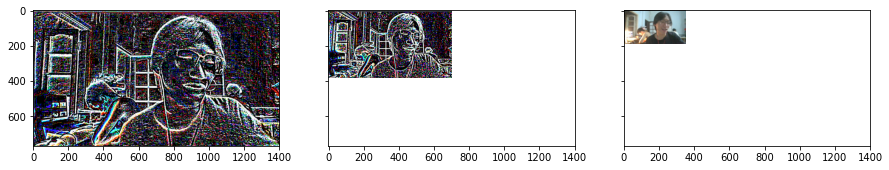

In [427]:
L=[]
for k in range(0,N-1):#pyramid levels
    l1=P[k]
    l2=P[k+1]
    l2=cv.resize(l2,(l1.shape[1],l1.shape[0])) # up-sample
    D=l1-l2
    D=D-np.min(D) #scale in [0,1]
    D=D/np.max(D) # for display purposes
    L.append(D)
L.append(P[N-1])
#display pyramid
fig,ax=plt.subplots(nrows=1,ncols=N,figsize=(15,7),dpi=72,sharex=True,sharey=True)
for k in range(N-1,-1,-1):
    ax[k].imshow(L[k])

# Steerable Pyramid

(770, 1401, 3)

# Wavelet Pyramid

# Delve into Gaussian Blur

In [357]:
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)
 
 
def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    kernel_1D = dnorm(kernel_1D, 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()
 
    return kernel_2D

In [265]:
def convolution(image, kernel, average=False, verbose=False):
    if len(image.shape) == 3:
        print("Found 3 Channels : {}".format(image.shape))
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        print("Image Shape : {}".format(image.shape))
 
    print("Kernel Shape : {}".format(kernel.shape))
 
    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()
 
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(image.shape)
 
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
 
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
 
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
 
    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()
 
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
 
    print("Output Image size : {}".format(output.shape))
 
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()
 
    return output
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)
 
 
def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()
 
    return kernel_2D
 
 
def gaussian_blur(image, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=np.sqrt(kernel_size), verbose=verbose)
    return convolution(image, kernel, average=True, verbose=verbose)
 

### Without normalizing kernel

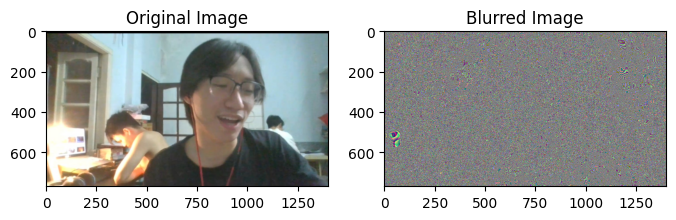

In [316]:

# Define the Gaussian kernel size and standard deviation
kernel_size = 60
sigma = 20

# Create a 2D Gaussian kernel
kernel = gaussian_kernel(kernel_size,sigma)


# Apply the Gaussian filter to each color channel separately
blurred_image = np.zeros_like(img, dtype=np.float32)
for i in range(3):
    blurred_image[:, :, i] = convolve(img[:, :, i], kernel)

# Alternatively, you can use the built-in gaussian_filter function


# Display the original and blurred images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(blurred_image.astype(int))
plt.title('Blurred Image')

plt.show()


### With normalizing kernel

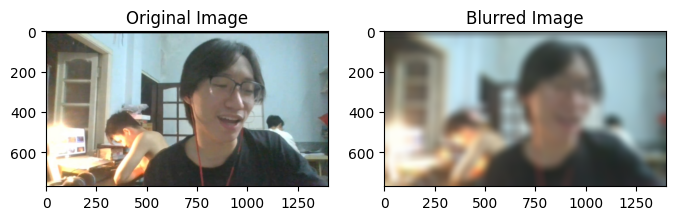

In [320]:

# Define the Gaussian kernel size and standard deviation
kernel_size = 61
sigma = 20

# Create a 2D Gaussian kernel
kernel = gaussian_kernel(kernel_size,sigma)

# Normalize the kernel to make the sum equal to 1. 
kernel_normalized = kernel/ np.sum(kernel) 

# Apply the Gaussian filter to each color channel separately
blurred_image = np.zeros_like(img, dtype=np.float32)
for i in range(3):
    blurred_image[:, :, i] = convolve(img[:, :, i], kernel_normalized)

# Alternatively, you can use the built-in gaussian_filter function


# Display the original and blurred images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(blurred_image.astype(int))
plt.title('Blurred Image')

plt.show()


# Separable Gaussian

### Faster than 2D kernel above

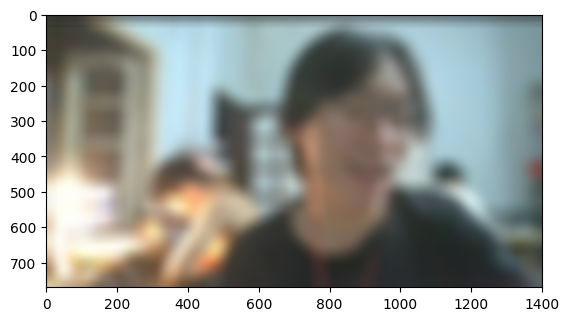

In [341]:
U,D,V=np.linalg.svd(kernel_normalized)
column_vector=U[:,0]
row_vector=V[0,:]*D[0]
convimg=np.zeros_like(img,dtype=np.float32)
for i in range(3):
    convimg[:,:,i]=sepfir2d(1.0*img[:,:,i],column_vector,row_vector)
plt.imshow(convimg.astype(int))
plt.show()
# plt.imshow(convimg.astype(int)-gauss_blurred)

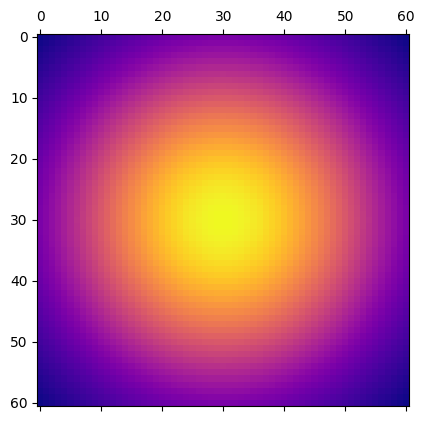

In [340]:
plt.matshow(np.hstack((kernel,)), cmap='plasma')

# Lowpass filter in Frequency domain

In [98]:
img_h = cv.imread('./img/Shinichi_Kudo.png')
img_h = cv.cvtColor(img_h, cv.COLOR_BGR2RGB)

In [24]:

# win=np.outer(np.hanning(img_h.shape[0]),np.hanning(img_h.shape[1]))
# win=gauss_blurred_msk.copy()
# win/=np.mean(win)

fft_img=np.zeros_like(img_h,dtype=complex)
for i in range(3):
    fft_img[:,:,i] = np.fft.fftshift(np.fft.fft2(img_h[:,:,i]))
# fft_img = 20*np.log(np.abs(fft_img))
# plt.imshow(fft_img.astype(int)) 
# plt.show()  
# im=np.zeros_like(img_h,dtype=np.float32)
# for i in range(3):
#     im[:,:,i] = img_h[:,:,i]*win
# plt.imshow(im.astype(int)) 
# plt.show() 
# filtered_fft_img=np.zeros_like(img_h,dtype=complex)
# for i in range(3):
#     filtered_fft_img[:,:,i] = np.fft.fftshift(np.fft.fft2(img_h[:,:,i]*win))
# filtered_fft_img1=filtered_fft_img.copy()
# filtered_fft_img = 20*np.log(np.abs(filtered_fft_img))
# plt.imshow(filtered_fft_img.astype(int)) 
# plt.show()  
# inverse fft
# ifft_img=np.zeros_like(img_h,dtype=np.complex128)
# filtered_fft=np.zeros_like(img_h,dtype=np.complex128)
# for i in range(3):
#     filtered_fft[:,:,i]= np.fft.ifftshift(filtered_fft_img1[:,:,i])
#     ifft_img[:,:,i] = np.fft.ifft2(filtered_fft[:,:,i])
# plt.imshow(np.abs(ifft_img).astype(int))
# plt.show()  
# # accuracy
# plt.imshow(abs(ifft_img - gauss_blurred))

### Gaussian transfer function

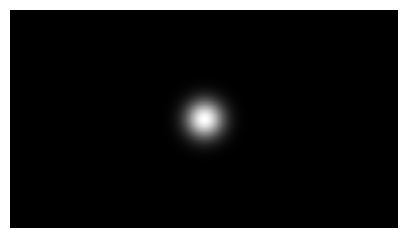

In [67]:
M,N = img_h.shape[0],img_h.shape[1]
H = np.zeros((M,N), dtype=np.float32)
D0 = 10
u, v = np.meshgrid(np.arange(M), np.arange(N))
D = np.sqrt((u-M/2)**2 + (v-N/2)**2).T
H = np.exp(-D**2/(2*D0*D0)).astype(np.float32)

plt.figure(figsize=(5,5))
plt.imshow(H, cmap='gray')
plt.axis('off')
plt.show()

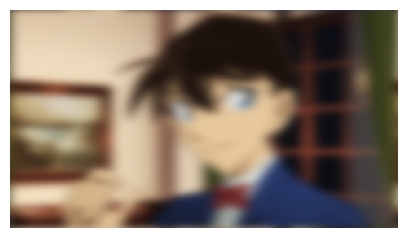

In [71]:
Gshift=np.zeros_like(img_h,dtype=np.complex128)
fft_img1=np.zeros_like(img_h,dtype=np.complex128)
for i in range(3):
    fft_img1[:,:,i]= np.fft.ifftshift(fft_img[:,:,i]*H)
    Gshift[:,:,i] = np.fft.ifft2(fft_img1[:,:,i])

g = np.abs(Gshift)

plt.figure(figsize=(5,5))
plt.imshow(g, cmap='gray')
plt.axis('off')
plt.show()

# Highpass filter → Laplacian Filter

In [471]:

def LoG_filter(sigma, size=None):
    if size is None:
        size = int(6 * sigma + 1) if sigma >= 1 else 7

    if size % 2 == 0:
        size += 1

    x, y = np.meshgrid(np.arange(-size//2+1, size//2+1), np.arange(-size//2+1, size//2+1))
    kernel = -(1/(np.pi * sigma**4)) * (1 - ((x**2 + y**2) / (2 * sigma**2))) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / np.sum(np.abs(kernel))
    return kernel

In [ ]:
l_kernel=LoG_filter(0.75)
# U,D,V=np.linalg.svd(l_kernel)
# column_vector=U[:,0]
# row_vector=V[0,:]*D[0]
# convimg=np.zeros_like(img,dtype=np.float32)
# for i in range(3):
#     convimg[:,:,i]=sepfir2d(1.0*img[:,:,i],column_vector,row_vector)
# plt.imshow(abs(convimg))
blurred_image = np.zeros_like(img, dtype=np.float32)
for i in range(3):
    blurred_image[:, :, i] = convolve(img[:, :, i], l_kernel)

# Alternatively, you can use the built-in gaussian_filter function


# Display the original and blurred images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(blurred_image.astype(int))
plt.title('Edge Image')

plt.show()

In [ ]:
muy, sigma_t = (0, 0.75)
# cut off frequency
h, w = (img_h.shape[0], img_h.shape[1])
sigma_f_x = w / (2 * np.pi * sigma_t)
sigma_f_y = h / (2 * np.pi * sigma_t)
x,y=np.meshgrid(np.linspace(- w // 2,  w // 2,w),np.linspace(- h // 2,  h // 2,h))
gauss_blurred_msk =  -(1/(np.pi * sigma_t**4)) * (1 - ((x**2 + y**2) / (2 * sigma_t**2))) * np.exp(-(x**2 + y**2) / (2 * sigma_t**2))
gauss_blurred_msk = gauss_blurred_msk / np.sum(np.abs(gauss_blurred_msk))
win=gauss_blurred_msk.copy()
win=np.max(win)-win
# win/=np.mean(win)

fft_img=np.zeros_like(img_h,dtype=complex)
for i in range(3):
    fft_img[:,:,i] = np.fft.fftshift(np.fft.fft2(img_h[:,:,i]))
fft_img = 20*np.log(np.abs(fft_img))
plt.imshow(fft_img.astype(int)) 
plt.show() #
 
im=np.zeros_like(img_h,dtype=np.float32)
for i in range(3):
    im[:,:,i] = img_h[:,:,i]*win
plt.imshow(im.astype(int)) 
plt.show() #
filtered_fft_img=np.zeros_like(img_h,dtype=complex)
for i in range(3):
    filtered_fft_img[:,:,i] = np.fft.fftshift(np.fft.fft2(img_h[:,:,i]))*np.fft.fftshift(np.fft.fft2(win))
filtered_fft_img1=filtered_fft_img.copy()
filtered_fft_img = 20*np.log(np.abs(filtered_fft_img))
plt.imshow(filtered_fft_img.astype(int)) 
plt.show()  # 
# inverse fft
ifft_img=np.zeros_like(img_h,dtype=np.complex128)
filtered_fft=np.zeros_like(img_h,dtype=np.complex128)
for i in range(3):
    filtered_fft[:,:,i]= np.fft.ifftshift(filtered_fft_img1[:,:,i])
    ifft_img[:,:,i] = np.fft.ifft2(filtered_fft[:,:,i])
plt.imshow(np.abs(ifft_img).astype(int))
plt.show()  
# # accuracy
# plt.imshow(abs(ifft_img - gauss_blurred))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


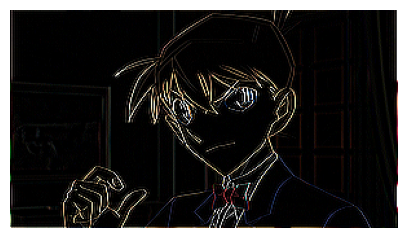

In [114]:
img_h = cv.imread('./img/Shinichi_Kudo.png')
img_h = cv.cvtColor(img_h, cv.COLOR_BGR2RGB)
H_L = -4*np.pi*np.pi*((u-M/2)**2 + (v-N/2)**2).T
fft_img=np.zeros_like(img_h,dtype=complex)
for i in range(3):
    fft_img[:,:,i] = np.fft.fftshift(np.fft.fft2(img_h[:,:,i]))

Gshift=np.zeros_like(img_h,dtype=np.complex128)
fft_img1=np.zeros_like(img_h,dtype=np.complex128)
for i in range(3):
    fft_img1[:,:,i]= np.fft.ifftshift(fft_img[:,:,i]*H_L)/255 # clip 
    Gshift[:,:,i] = np.fft.ifft2(fft_img1[:,:,i]) /255#clip
Lap = np.real(Gshift)
plt.figure(figsize=(5,5))
plt.imshow(Lap.astype(int))
plt.axis('off')
plt.show()
